In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random

In [2]:
import os

In [3]:
tf.debugging.set_log_device_placement(True)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [5]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/black_bear
oregon_wildlife/cougar
oregon_wildlife/red_fox
oregon_wildlife/raven
oregon_wildlife/bald_eagle
oregon_wildlife/raccoon
oregon_wildlife/nutria
oregon_wildlife/virginia_opossum
oregon_wildlife/deer
oregon_wildlife/sea_lions

total img num: 7168


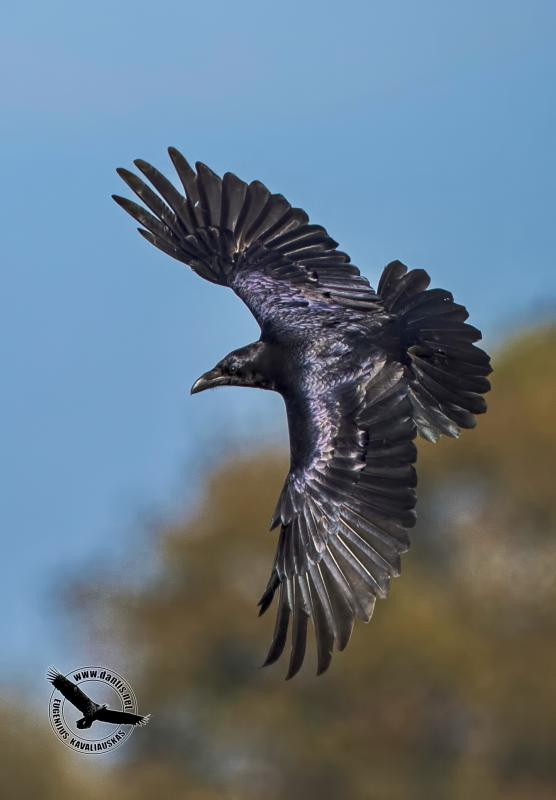

raven


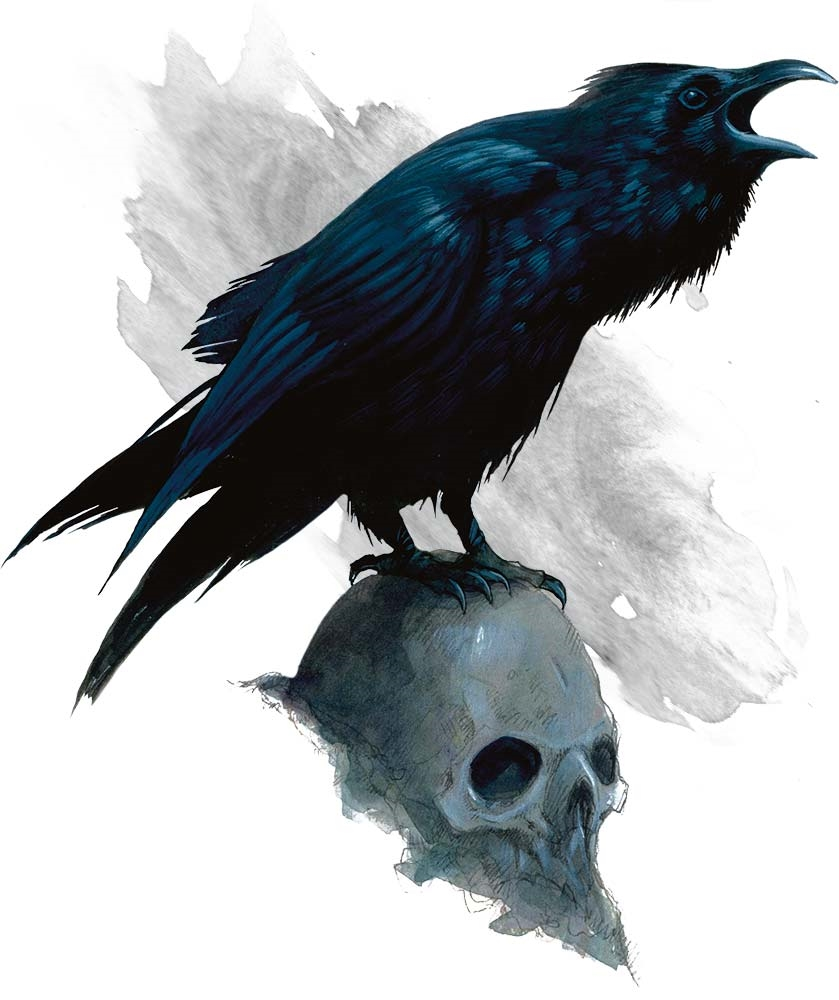

raven


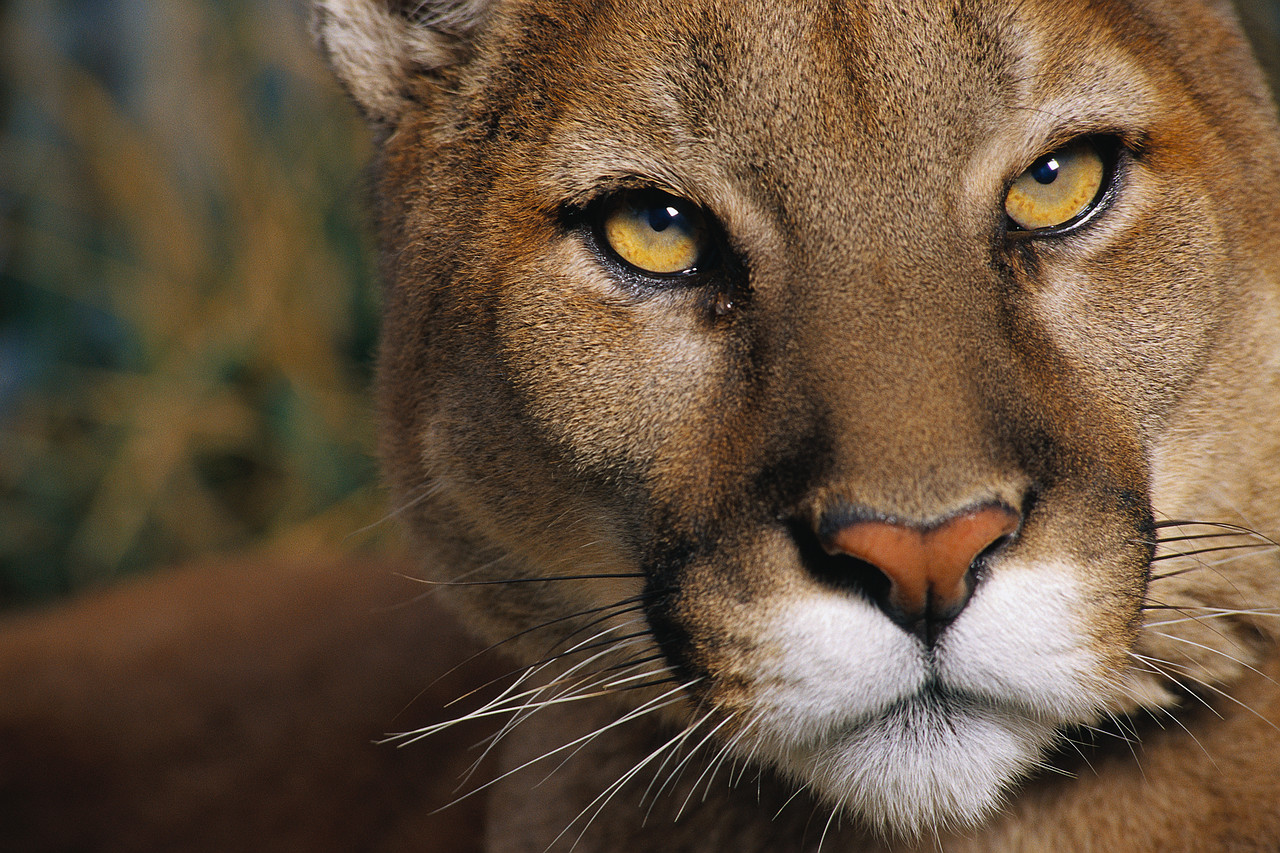

cougar


In [6]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [7]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)  #number of classes
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [8]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)
print(index_to_label)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}
{0: 'bald_eagle', 1: 'black_bear', 2: 'cougar', 3: 'deer', 4: 'nutria', 5: 'raccoon', 6: 'raven', 7: 'red_fox', 8: 'sea_lions', 9: 'virginia_opossum'}


In [9]:
print(index_to_label[1])
print(label_to_index['bald_eagle'])

black_bear
0


In [10]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 5, 7, 5, 2, 7, 2, 1, 2, 1]


In [11]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [12]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


# feel free to modify these Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [13]:
# load images
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img, label

In [14]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train))
dataset_train = dataset_train.map(load_image)

dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val))
dataset_val = dataset_val.map(load_image)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [15]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

In [16]:
def tf_serialize_example(f0,f1,f2,f3):
    tf_string = tf.py_function(
        serialize_example,
        (f0,f1,f2,f3),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

# My work: 
# todo1:
# write the dataset above to tfrecord

In [17]:
def _parse_mapdataset_to_TFWrite(mapdataset, filepath):
    with tf.io.TFRecordWriter(filepath) as file_writer:
        for image, label in mapdataset:
            #image, label = next(iter(mapdataset))
            features={
                'height': _int64_feature(300),
                'width': _int64_feature(300),
               # 'depth': _int64_feature(3),
                'label': _int64_feature(label),
                'image_raw':_bytes_feature(serialize_array(image))
            }

            out = tf.train.Example(features=tf.train.Features(feature=features))
            file_writer.write(out.SerializeToString())
#writer.close()
#print(count)
_parse_mapdataset_to_TFWrite(dataset_train, 'tfcord_train')
_parse_mapdataset_to_TFWrite(dataset_val, 'tfcord_val')

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SerializeTensor in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SerializeTensor in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SerializeTensor in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SerializeTensor in device /job:localhost/replica:0/task:0/device:

# My work: 
# todo2:
# read the data from tfrecord you get in Todo1

In [18]:
data_train = tf.data.TFRecordDataset('tfcord_train')

Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [19]:
data_val = tf.data.TFRecordDataset('tfcord_val')

Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [21]:
def _parse_record(data):

# 將數據反序列化為結構化的數據

    features = {
    'height': tf.io.FixedLenFeature([],tf.int64),
    'width': tf.io.FixedLenFeature([],tf.int64),
    'label': tf.io.FixedLenFeature([],tf.int64),
    'image_raw': tf.io.FixedLenFeature([],tf.string)}

    parsed_features = tf.io.parse_single_example(data, features=features)

    return parsed_features



In [22]:
def parse_tfr_elem(element):
    parse_dict = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width':tf.io.FixedLenFeature([], tf.int64),
        'label':tf.io.FixedLenFeature([], tf.int64),
        #'depth':tf.io.FixedLenFeature([], tf.int64),
        'image_raw' : tf.io.FixedLenFeature([], tf.string)
    }
    example_message = tf.io.parse_single_example(element, parse_dict)

    img_raw = example_message['image_raw']
    height = example_message['height']
    width = example_message['width']
    label = example_message['label']
    #img=tf.io.decode_image(img_raw, dtype=tf.dtypes.float32)
    print(img_raw)

    #feature = tf.io.parse_tensor(img, out_type=tf.float32)
    feature = tf.io.parse_tensor(img_raw, out_type=tf.float32)
    feature = tf.reshape(feature, shape=[height,width,3])
    return (feature, label)

In [23]:
def get_dataset(filename, set_type):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable native order, increase speed
    dataset = tf.data.TFRecordDataset(filename)
    
    dataset = dataset.with_options(
        ignore_order
    )  

    dataset = dataset.map(parse_tfr_elem)
    #dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
    #dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [62]:
tfr_dataset_train = get_dataset('tfcord_train', "train")
tfr_dataset_val = get_dataset('tfcord_val', "train")

for sample in tfr_dataset_train.take(1):
    print(sample[0], "\n==============\n", sample[1])

Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=string)
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Tensor("ParseSingleExample/ParseExample/ParseExampleV2:1", shape=(), dtype=string)
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDa

In [43]:
import numpy as np
def _parse_mapdataset(mapdataset):
    img = np.array([])
    lab = np.array([])
    for feature, label in mapdataset:
        img = np.vstack([img, feature])
        lab = np.vstack([lab, label])

    return feature, label
    

# end of todo2:


# My work: 
# todo 3:
# Couldn't finish it

In [57]:
# transform a 3-channel image into one channel
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r = np.asarray(.3, dtype=dtype)
    g = np.asarray(.59, dtype=dtype)
    b = np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

In [58]:
def getfeat(image,
               stride=8,
               orientations=8,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2)):
    cx, cy = pixels_per_cell
    bx, by = cells_per_block
    sx, sy, sz = image.shape
    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y
    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    gx = np.zeros((sx, sy), dtype=np.double)
    gy = np.zeros((sx, sy), dtype=np.double)
    eps = 1e-5
    grad = np.zeros((sx, sy, 2), dtype=np.double)
    for i in range(1, sx - 1):
        for j in range(1, sy - 1):
            gx[i, j] = image[i, j - 1] - image[i, j + 1]
            gy[i, j] = image[i + 1, j] - image[i - 1, j]
            grad[i, j, 0] = np.arctan(gy[i, j] / (gx[i, j] + eps)) * 180 / math.pi
            if gx[i, j] < 0:
                grad[i, j, 0] += 180
            grad[i, j, 0] = (grad[i, j, 0] + 360) % 360
            grad[i, j, 1] = np.sqrt(gy[i, j] ** 2 + gx[i, j] ** 2)
    normalised_blocks = np.zeros((n_blocksy, n_blocksx, by * bx * orientations))
    for y in range(n_blocksy):
        for x in range(n_blocksx):
            block = grad[y * stride:y * stride + 16, x * stride:x * stride + 16]
            hist_block = np.zeros(32, dtype=np.double)
            eps = 1e-5
            for k in range(by):
                for m in range(bx):
                    cell = block[k * 8:(k + 1) * 8, m * 8:(m + 1) * 8]
                    hist_cell = np.zeros(8, dtype=np.double)
                    for i in range(cy):
                        for j in range(cx):
                            n = int(cell[i, j, 0] / 45)
                            hist_cell[n] += cell[i, j, 1]
                    hist_block[(k * bx + m) * orientations:(k * bx + m + 1) * orientations] = hist_cell[:]
            normalised_blocks[y, x, :] = hist_block / np.sqrt(
                hist_block.sum() ** 2 + eps)
    return normalised_blocks.ravel()

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[[0.3616536  0.35381046 0.30675164]
  [0.47328106 0.47524184 0.4272026 ]
  [0.3867876  0.4050425  0.35014054]
  ...
  [0.8034935  0.9466307  0.7868268 ]
  [0.803866   0.9411209  0.7842582 ]
  [0.80613077 0.9394641  0.79436606]]

 [[0.38417646 0.37815687 0.33109805]
  [0.45441177 0.45880392 0.409549  ]
  [0.4537843  0.4753529  0.42045096]
  ...
  [0.8081471  0.9532451  0.7924608 ]
  [0.81291175 0.95212746 0.7942843 ]
  [0.8151764  0.9485098  0.8034117 ]]

 [[0.33060458 0.3368464  0.2866

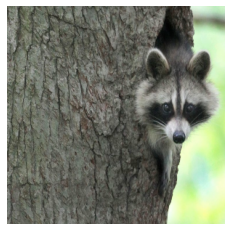

raccoon
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


In [55]:
# show one image here.
for feauture, label in tfr_dataset_train.take(1):
    print(feauture)
    #print(feauture[0].shape)
    plt.imshow(feauture) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label.numpy()])

In [ ]:
def map_shuffle_batch(data):
    data = data.map(_parse_record)
    data = data.shuffle(buffer_size=10000)
    data = data.batch(32)
    return data

data_train = map_shuffle_batch(data_train)
data_val = map_shuffle_batch(data_val)

In [53]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica

In [64]:
wild_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

wild_model.summary()

wild_model.fit(tfr_dataset_traintfr_dataset_train, validation_data=tfr_dataset_val, batch_size=32, epochs=5)

Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:lo

ValueError: in user code:

    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:385 call
        return self._run_internal_graph(
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/wilsonhong/miniconda3/envs/dl/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:191 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer block1_conv1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, None, 3]
